# Importando bibliotecas e dependências

In [402]:
!pip install ucimlrepo

In [403]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
import pytensor.tensor as tt
from sklearn.preprocessing import LabelEncoder as LB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.cluster import KMeans

# Breast Cancer Wisconsin (id=17)

## Importando e tratando dataset

In [404]:
breast_cancer = fetch_ucirepo(id=17)

In [405]:
breast_cancer = breast_cancer.data.original #transforma em dataframe
breast_cancer = breast_cancer.set_index('ID')

In [406]:
breast_cancer.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
ID,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


In [407]:
#substituindo categorias por valores numéricos
breast_cancer['Diagnosis'] = breast_cancer['Diagnosis'].replace({'B':0,'M':1}) # 0 para Benigno; 1 para Maligno

In [408]:
# Calcula a correlação de cada coluna com a coluna 'Diagnosis'
correlations = breast_cancer.corr()['Diagnosis'].abs()

# Remove a coluna 'Diagnosis'
correlations = correlations.drop('Diagnosis')

# Ordena as colunas pela correlação e seleciona as 10 menores
least_correlated = correlations.nlargest(7).index

# Adiciona as colunas 'Diagnosis' à lista de colunas selecionadas
least_correlated = ['Diagnosis'] + least_correlated.tolist()

# Seleciona as colunas do DataFrame original
breast_cancer_selected = breast_cancer[least_correlated]

# Exibe o DataFrame com as colunas selecionadas
breast_cancer_selected.head()

,Diagnosis,concave_points3,perimeter3,concave_points1,radius3,perimeter1,area3,radius1
ID,,,,,,,,
842302,1,0.2654,184.60,0.14710,25.38,122.80,2019.0,17.99
842517,1,0.1860,158.80,0.07017,24.99,132.90,1956.0,20.57
84300903,1,0.2430,152.50,0.12790,23.57,130.00,1709.0,19.69
84348301,1,0.2575,98.87,0.10520,14.91,77.58,567.7,11.42
84358402,1,0.1625,152.20,0.10430,22.54,135.10,1575.0,20.29


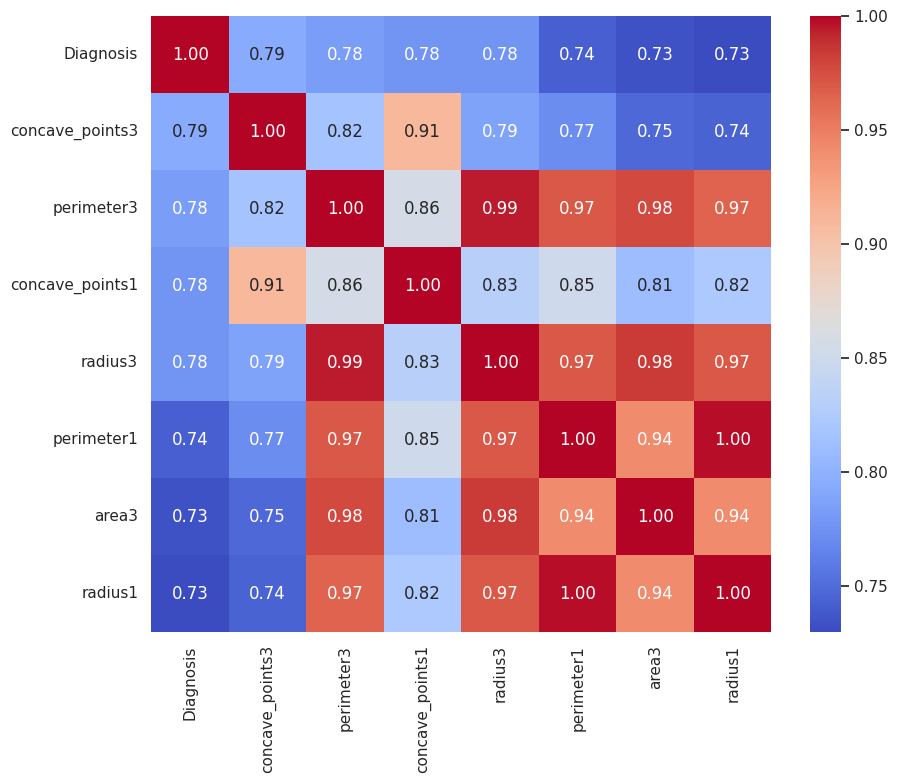

In [409]:
#plotando gráfico de correlação
plt.figure(figsize=(10,8))
sns.heatmap(breast_cancer_selected.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

#apesar das variaveis estarem altamento correlacionadas entre si, iremos usar todas, pois o dataset tem poucas linhas e colunas

In [410]:
#atribuindo o nome das variáveis independentes a um dicionário com chave chamada "features"
breast_coords = {
    'features': breast_cancer_selected.columns.tolist()[1:]
}

In [411]:
#separando features(variaveis independentes) e target(variavel dependente)
breast_X_f = breast_cancer_selected.drop('Diagnosis', axis=1)
breast_y = breast_cancer_selected['Diagnosis'] #target

In [412]:
#separando dataset entre amostras de treino e teste
breast_X_train, breast_X_test, breast_y_train, breast_y_test = train_test_split(breast_X_f, breast_y, test_size=0.3)

## Preditiva a Priori

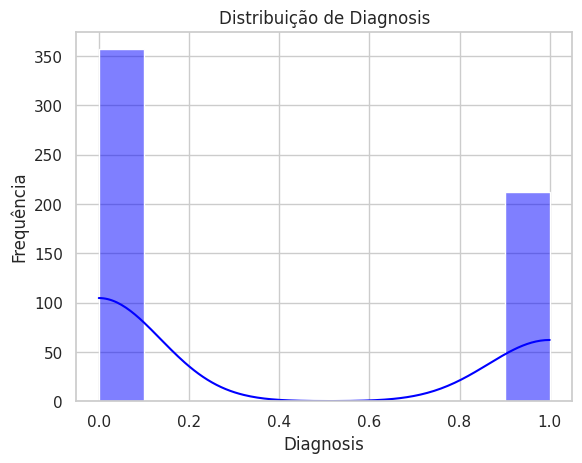

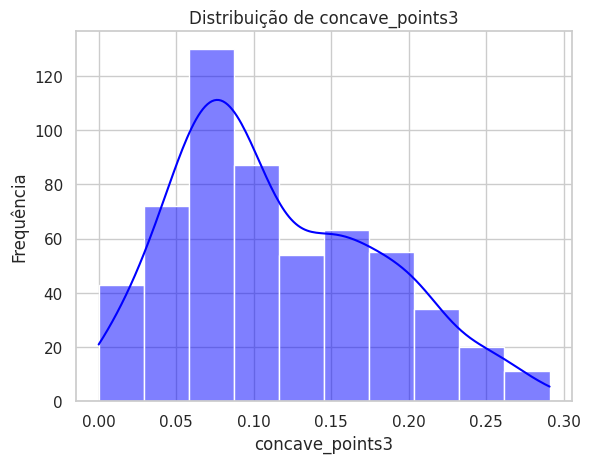

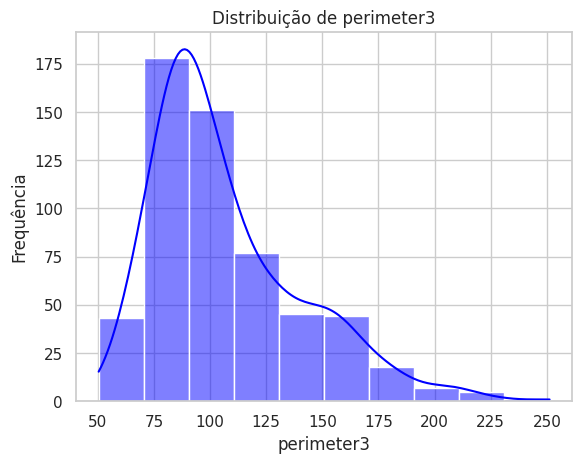

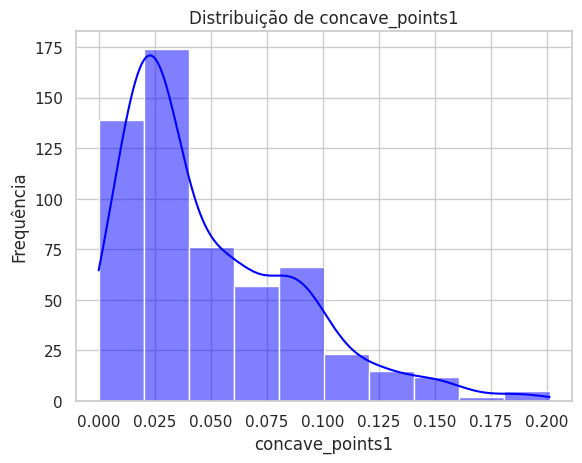

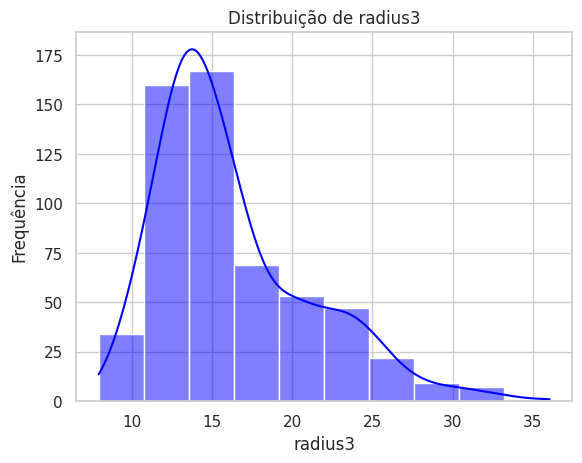

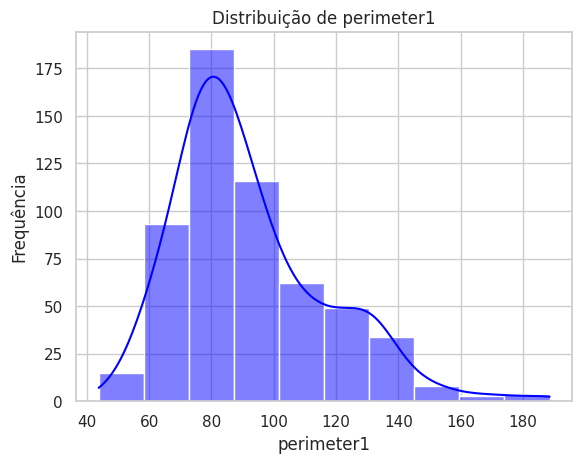

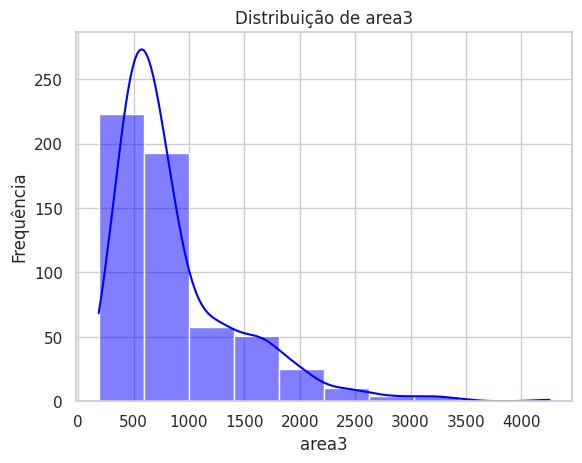

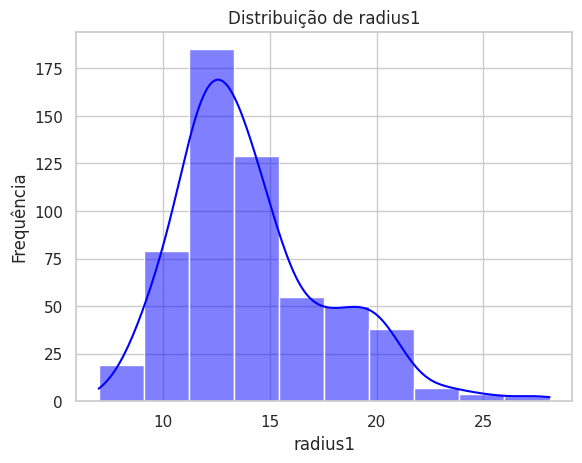

In [413]:
#plotando a distribuição de todas as variáveis
#aqui podemos escolher as distribuições mais adequadas pro modelo
#lembrar que a ultima coluna são as classes da variável resposta, que é binaria
sns.set(style="whitegrid")

for column in breast_cancer_selected.columns:
    plt.figure()
    sns.histplot(breast_cancer_selected[column], bins=10, kde=True, color='blue', alpha=0.5)
    plt.title(f'Distribuição de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.show()

In [414]:
#aqui conseguimos colher parametros para as distribuições do modelo
breast_cancer_selected.describe()

,Diagnosis,concave_points3,perimeter3,concave_points1,radius3,perimeter1,area3,radius1
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,0.114606,107.261213,0.048919,16.269190,91.969033,880.583128,14.127292
std,0.483918,0.065732,33.602542,0.038803,4.833242,24.298981,569.356993,3.524049
min,0.000000,0.000000,50.410000,0.000000,7.930000,43.790000,185.200000,6.981000
25%,0.000000,0.064930,84.110000,0.020310,13.010000,75.170000,515.300000,11.700000
50%,0.000000,0.099930,97.660000,0.033500,14.970000,86.240000,686.500000,13.370000
75%,1.000000,0.161400,125.400000,0.074000,18.790000,104.100000,1084.000000,15.780000
max,1.000000,0.291000,251.200000,0.201200,36.040000,188.500000,4254.000000,28.110000


## Modelo 1 - Regressão de Ridge

In [415]:
with pm.Model(coords=breast_coords) as breast_model_1:
  betas = pm.Normal("beta",0,1,dims="features")
  alpha = pm.Normal("alpha",0,1)

  X = [
    pm.MutableData("breast_X_"+column,breast_X_train[column].values)
    for column in breast_X_train.columns if np.issubdtype(breast_X_f[column].dtype, np.number)
  ]

  y = pm.MutableData("y",breast_y_train)

  mu = alpha + tt.dot(betas,X)
  likelihood = pm.Bernoulli("likelihood",pm.math.invlogit(mu),observed=y)

/usr/local/lib/python3.10/dist-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [416]:
#aqui usaremos somente o pm.sample para criar um amostra com os parametros que passamos para o modelo
#pm.sample direto pois a amostra é pequena
#caso contrário, poderiamos usar o pm.fit para ajustar a aproximação dos parâmetros que inserimos
with breast_model_1:
  breast_trace = pm.sample(10000)

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 20000 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [417]:
#visualizando as estatísticas da amostra (r_rat adequado)
pm.summary(breast_trace)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (be

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.298,0.627,-0.926,0.329,0.443,0.376,2.0,2.0,2326720.73
beta[concave_points3],-0.143,0.403,-0.545,0.260,0.285,0.241,2.0,2.0,2326720.73
beta[perimeter3],-0.085,0.340,-0.425,0.256,0.241,0.204,2.0,2.0,2326720.73
beta[concave_points1],0.381,0.335,0.046,0.716,0.237,0.201,2.0,2.0,2326720.73
beta[radius3],0.435,0.519,-0.084,0.953,0.367,0.311,2.0,2.0,2326720.73
beta[perimeter1],0.140,0.315,-0.175,0.454,0.222,0.188,2.0,2.0,2326720.73
beta[area3],0.540,0.399,0.141,0.939,0.282,0.239,2.0,2.0,2326720.73
beta[radius1],-0.426,0.318,-0.744,-0.108,0.225,0.190,2.0,2.0,2326720.73


/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

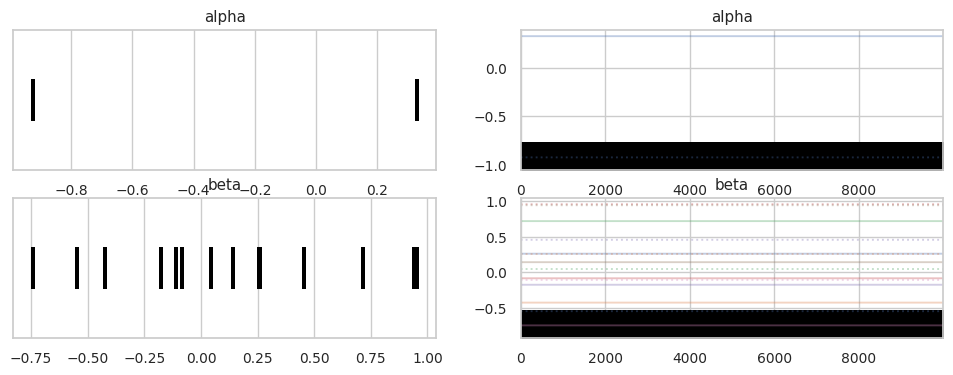

In [418]:
#gráficos das distribuições da amostra
az.plot_trace(breast_trace)

In [419]:
#criando um dicionário que a chave carregará o nome de XNomeDaFeature e os valores de cada feature(variavel)
breast_vars = {"breast_X_"+column : breast_X_test[column].values
    for column in breast_X_test.columns if np.issubdtype(breast_X_test[column].dtype, np.number)}
breast_vars["y"] = breast_y_test

In [420]:
#aplicando a previsão do modelo na amostra a posteriori
with breast_model_1:
  pm.set_data(breast_vars)
  breast_trace_post = pm.sample_posterior_predictive(breast_trace)

Output()

In [421]:
#tirando a media da previsão do modelo no likelihood(observado)
breast_mean_likelihood = breast_trace_post.posterior_predictive['likelihood'].mean(dim=['chain', 'draw'])
#classificando as previsões
breast_binary_predictions = (breast_mean_likelihood > 0.5).astype(int)

In [422]:
#criando um dataframe que receberá uma coluna com os valores de predição e outra com valores de 1=erro e 0=acerto
brest_abs_diff = np.abs(breast_y_test - breast_binary_predictions)

breast_df = pd.DataFrame({
    'concave_points3': breast_X_test["concave_points3"],
    'y_test': breast_y_test,
    'binary_predictions': breast_binary_predictions,
    'abs_diff': brest_abs_diff
})

In [423]:
#calculando a acurácia
errors = breast_df["abs_diff"].sum()
acc = (len(breast_df)-errors)/len(breast_df)
print(f"Acuracia: {acc:.4f}")
print(f"Erros: {errors}")

Acuracia: 0.3918
Erros: 104


In [424]:
#A acurácia pode não ser a melhor métrica para modelos de classificação, principalmente quando a amostra é desbalanceada
#Por isso, outras formas de se metrificar modelos é através das técnicas de precisão, recall e f1-score

precision = precision_score(breast_y_test, breast_binary_predictions)

recall = recall_score(breast_y_test, breast_binary_predictions)

f1 = f1_score(breast_y_test, breast_binary_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.3918
Recall: 1.0000
F1 Score: 0.5630


# Auto MPG (id=9)

## Importando e tratando o dataset

In [425]:
auto = fetch_ucirepo(id=9)

In [426]:
auto = auto.data.original

In [427]:
auto = auto[~auto.isnull().any(axis=1)]

In [428]:
auto.head()

,car_name,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,"chevrolet,chevelle,malibu",8,307.0,130.0,3504,12.0,70,1,18.0
1,"buick,skylark,320",8,350.0,165.0,3693,11.5,70,1,15.0
2,"plymouth,satellite",8,318.0,150.0,3436,11.0,70,1,18.0
3,"amc,rebel,sst",8,304.0,150.0,3433,12.0,70,1,16.0
4,"ford,torino",8,302.0,140.0,3449,10.5,70,1,17.0


In [429]:
# Tentei fazer com que o modelo pudesse utilizar o nome do carro como feature,
#  mas, por conta do esforço, notei que não valeria a pena.
'''max_commas = auto['car_name'].str.count(',').max()
car_name_cols = [f'car_name{i+1}' for i in range(max_commas + 1)]
auto_selected[car_name_cols] = auto_selected['car_name'].str.split(',', expand=True)
auto_selected = auto_selected.drop('car_name', axis=1)'''

auto = auto.drop('car_name', axis=1)

In [430]:
auto_X = auto.drop(columns=['mpg'])

In [431]:
auto_Y = auto['mpg']

## Preditiva a Priori

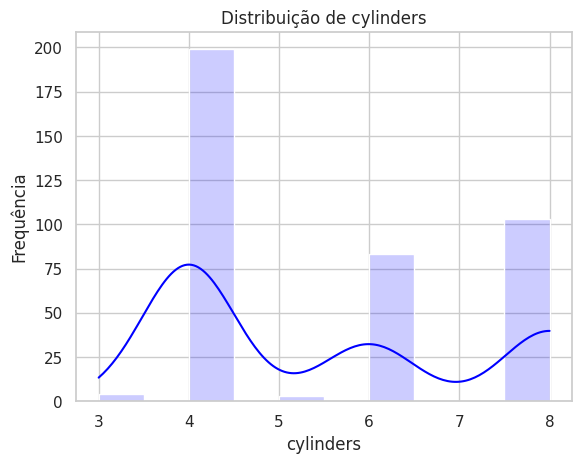

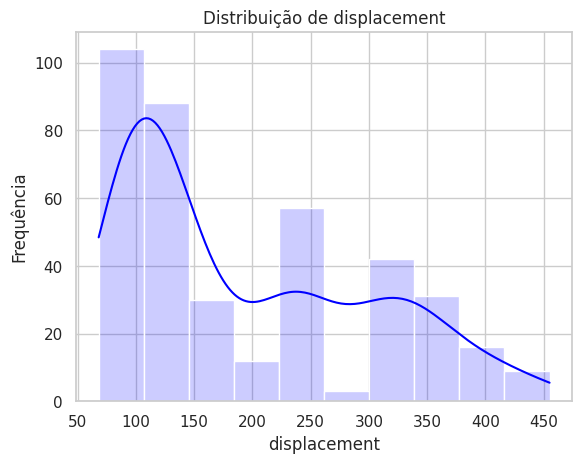

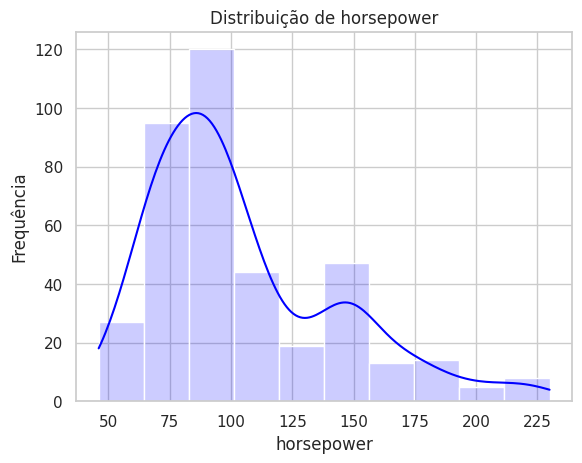

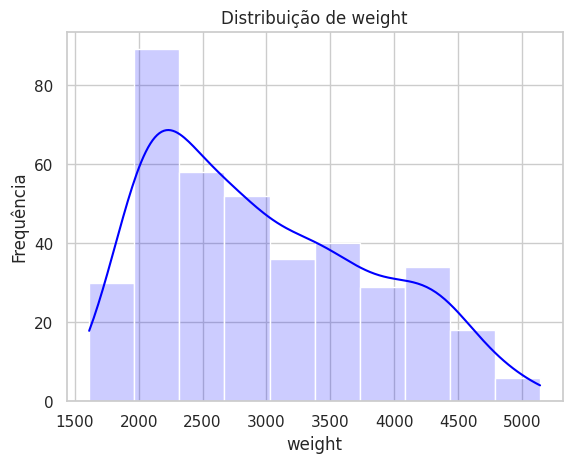

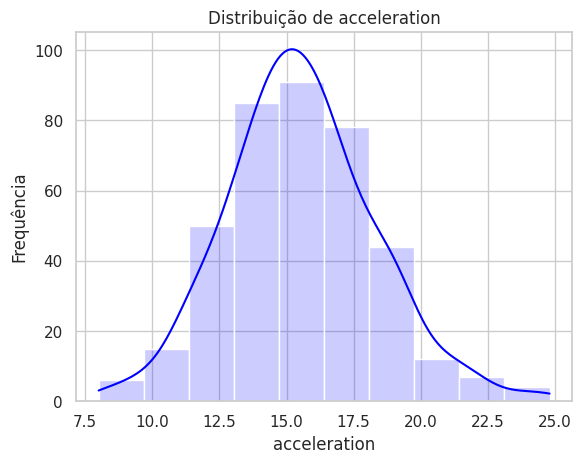

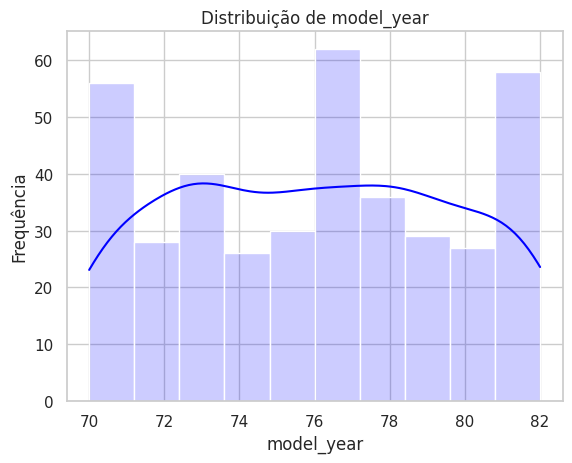

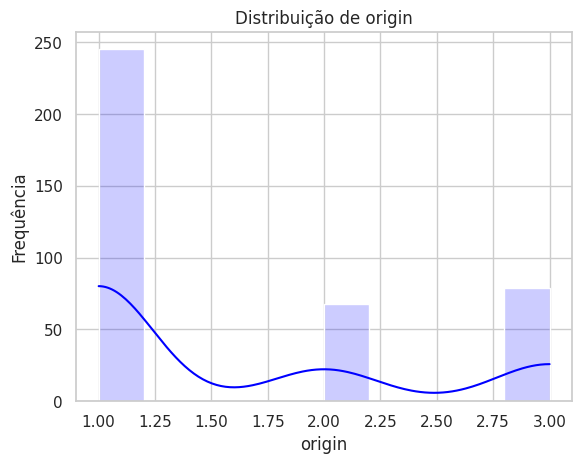

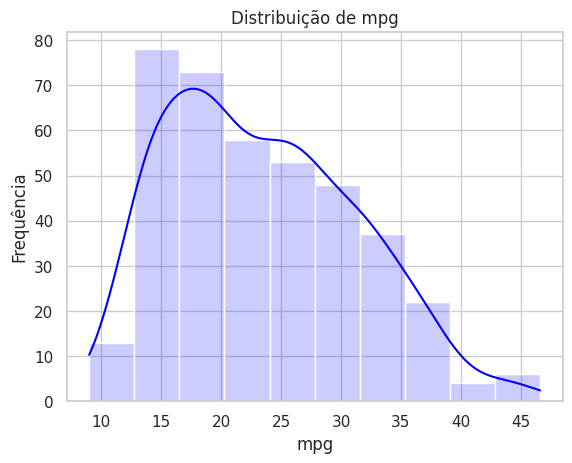

In [432]:
#plotando a distribuição de todas as variáveis
#aqui podemos escolher as distribuições mais adequadas pro modelo
#lembrar que a ultima coluna são as classes da variável resposta, que é binaria
sns.set(style="whitegrid")

for column in auto.columns:
    plt.figure()
    sns.histplot(auto[column], bins=10, kde=True, color='blue', alpha=0.2)
    plt.title(f'Distribuição de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.show()

In [433]:
#aqui conseguimos colher parametros para as distribuições do modelo
auto.describe()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531,23.445918
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518,7.805007
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000,17.000000
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,22.750000
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


## Normalizando os dados

In [434]:
scaler = StandardScaler()

In [435]:
#se fizermos a preditiva a priori no começo e colhermos bons parametros pro no modelo, não precisa normalizar os dados
auto_X_normalizado = scaler.fit_transform(auto_X)

In [436]:
auto_X_normalizado = pd.DataFrame(auto_X_normalizado,columns=auto_X.columns)

## Prever a área

### Modelo 1 - regressão multilinear

In [437]:
#atribuindo o nome das variáveis independentes a um dicionário com chave chamada "features"
auto_coords = {
    'features': (auto.drop('mpg', axis=1)).columns.tolist()
}

In [438]:
with pm.Model(coords=auto_coords) as auto_reg_model_1:
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 1, dims='features')

    mu = a + tt.dot(auto_X_normalizado, b)

    eps = pm.HalfNormal("eps", 1)

    likelihood = pm.Normal("y_obs", mu, eps, observed=auto_Y)

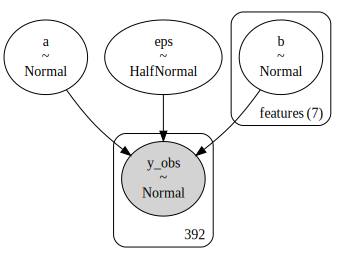

In [439]:
pm.model_to_graphviz(auto_reg_model_1)

In [440]:
# O modelo não está se ajustando as variáveis da Regressão multilinear
with auto_reg_model_1:
  auto_trace = pm.sample()

Output()

Output()

In [441]:
pm.summary(auto_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,22.777,0.175,22.426,23.092,0.004,0.003,2476.0,1592.0,1.0
b[cylinders],-0.600,0.457,-1.508,0.221,0.011,0.008,1856.0,1513.0,1.0
b[displacement],0.605,0.603,-0.578,1.678,0.015,0.011,1624.0,1604.0,1.0
b[horsepower],-0.890,0.460,-1.756,-0.026,0.011,0.008,1687.0,1265.0,1.0
b[weight],-4.196,0.454,-5.045,-3.349,0.011,0.008,1560.0,1354.0,1.0
b[acceleration],-0.021,0.253,-0.507,0.422,0.006,0.005,1867.0,1707.0,1.0
b[model_year],2.606,0.188,2.250,2.963,0.004,0.003,2428.0,1564.0,1.0
b[origin],1.076,0.224,0.666,1.496,0.004,0.003,2565.0,1183.0,1.0
eps,3.377,0.123,3.152,3.616,0.003,0.002,2073.0,1532.0,1.0


array([[<Axes: title={'center': 'a'}>,
        <Axes: title={'center': 'b\ncylinders'}>,
        <Axes: title={'center': 'b\ndisplacement'}>],
       [<Axes: title={'center': 'b\nhorsepower'}>,
        <Axes: title={'center': 'b\nweight'}>,
        <Axes: title={'center': 'b\nacceleration'}>],
       [<Axes: title={'center': 'b\nmodel_year'}>,
        <Axes: title={'center': 'b\norigin'}>,
        <Axes: title={'center': 'eps'}>]], dtype=object)

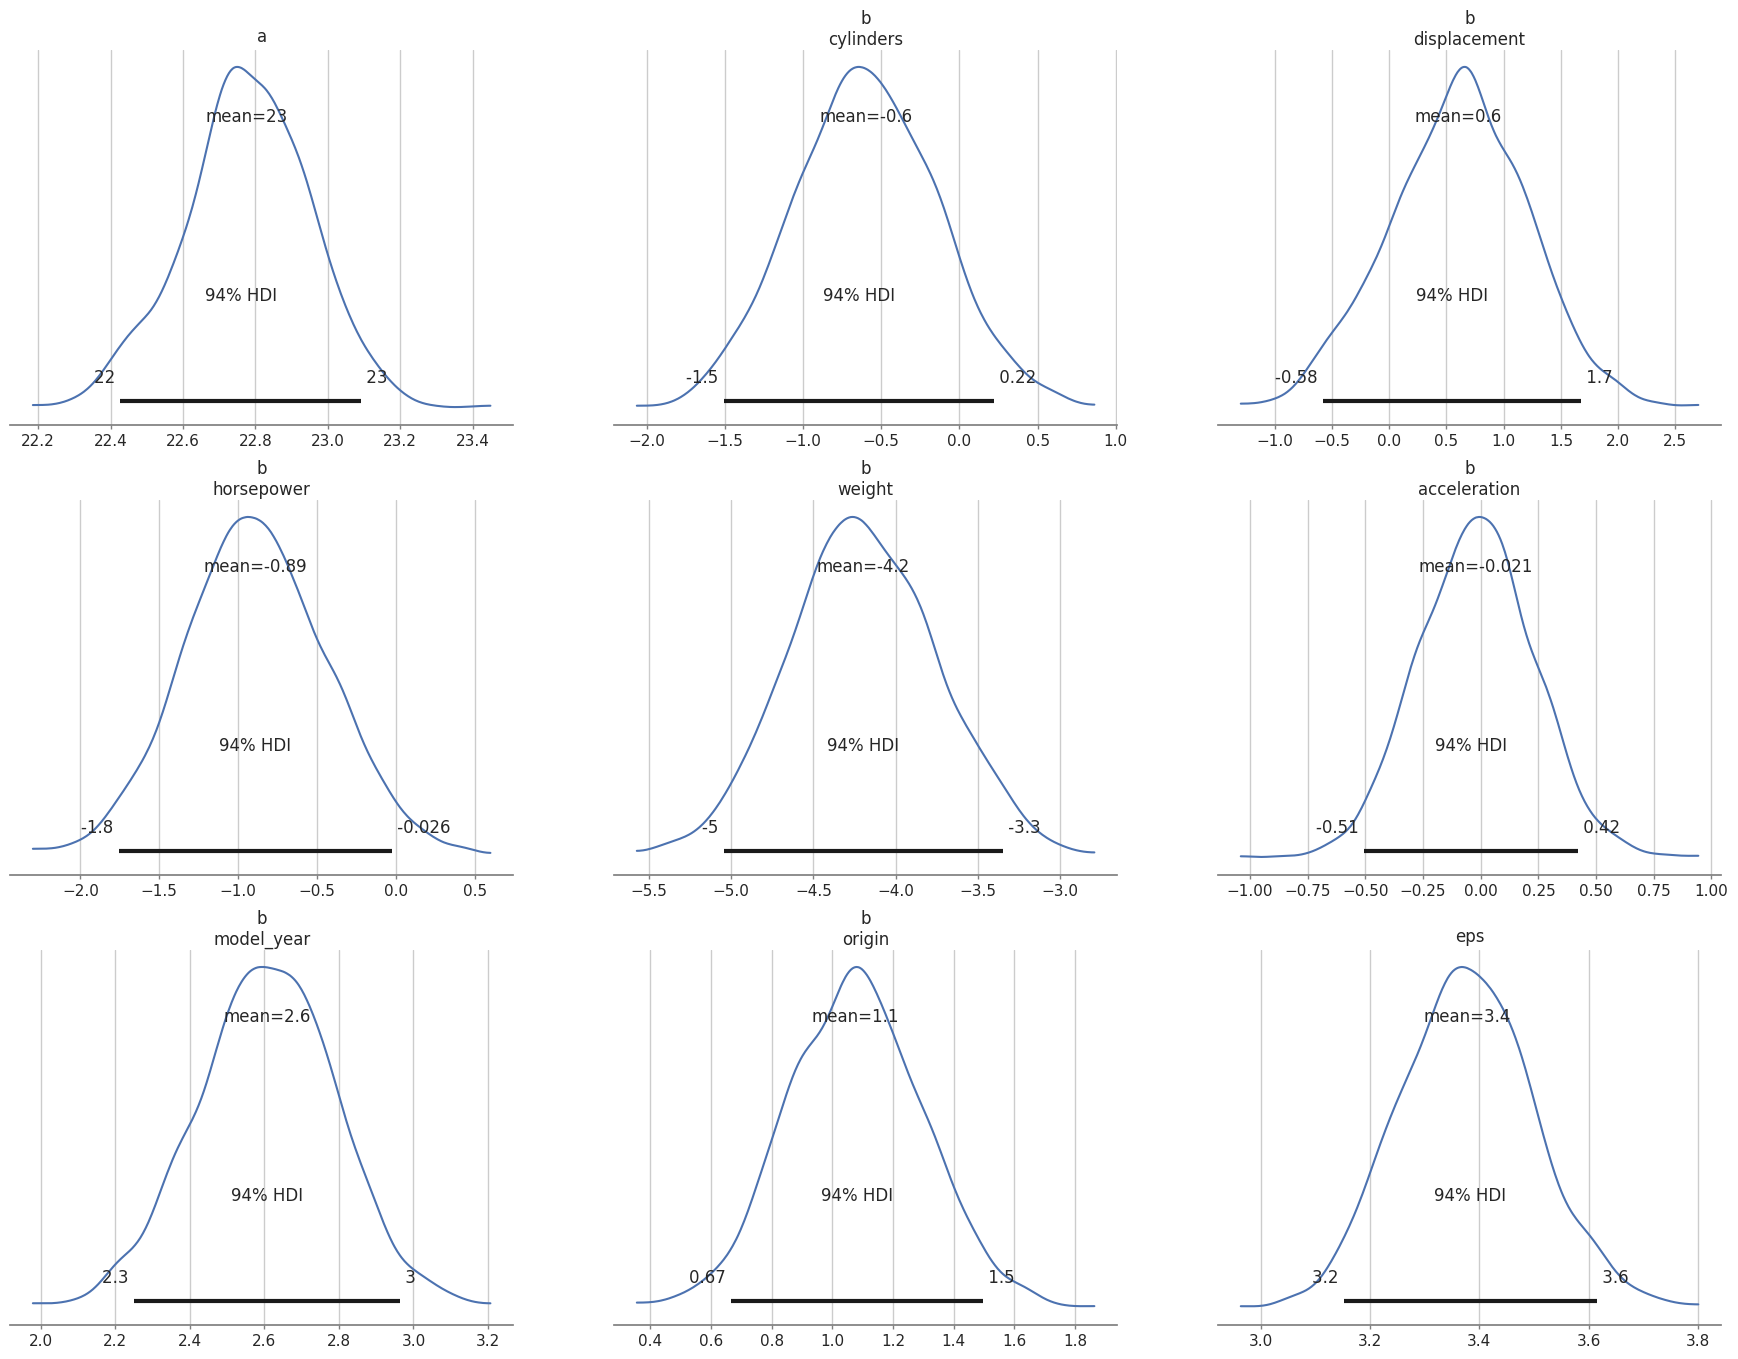

In [442]:
az.plot_posterior(auto_trace)

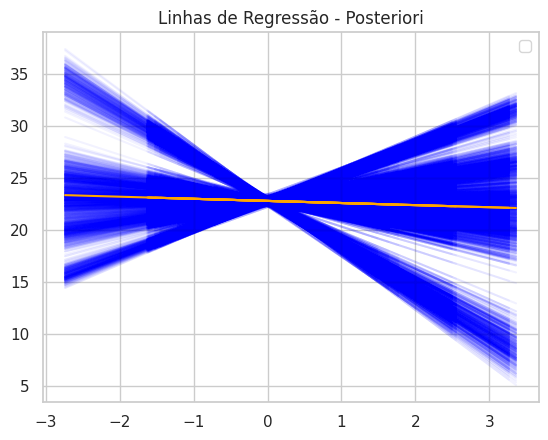

In [443]:
a_samples = auto_trace.posterior["a"].values.flatten()
b_samples = auto_trace.posterior["b"].values.flatten()
t_values = np.linspace(auto_X_normalizado.min(), auto_X_normalizado.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange")

#plt.scatter(t, obs, color="red", label="Observed Data", alpha=0.5)

plt.xlabel("")
plt.ylabel("")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()


### Modelo 2 - regressão de lasso

In [444]:
with pm.Model(coords=auto_coords) as auto_reg_lasso:
    a = pm.Laplace("a", 0, 1)
    b = pm.Laplace("b", 0, 1, dims='features')

    mu = a + tt.dot(auto_X_normalizado, b)

    eps = pm.HalfNormal("eps", 1)

    likelihood = pm.Normal("y_obs", mu, eps, observed=auto_Y)

In [445]:
# O modelo não está se ajustando as variáveis da Regressão multilinear
with auto_reg_lasso:
  auto_trace_lasso = pm.sample()

Output()

Output()

In [446]:
pm.summary(auto_trace_lasso)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,23.416,0.167,23.117,23.746,0.003,0.002,2691.0,1443.0,1.0
b[cylinders],-0.401,0.449,-1.229,0.400,0.011,0.009,1691.0,1445.0,1.0
b[displacement],1.018,0.706,-0.258,2.353,0.019,0.015,1390.0,1117.0,1.0
b[horsepower],-0.501,0.460,-1.309,0.430,0.012,0.009,1457.0,1508.0,1.0
b[weight],-5.118,0.514,-6.054,-4.090,0.013,0.009,1668.0,1360.0,1.0
b[acceleration],0.148,0.235,-0.282,0.607,0.005,0.004,1847.0,1167.0,1.0
b[model_year],2.718,0.194,2.353,3.058,0.004,0.003,2281.0,1457.0,1.0
b[origin],1.030,0.217,0.600,1.417,0.005,0.003,2177.0,1354.0,1.0
eps,3.296,0.114,3.093,3.519,0.002,0.002,2358.0,1458.0,1.0


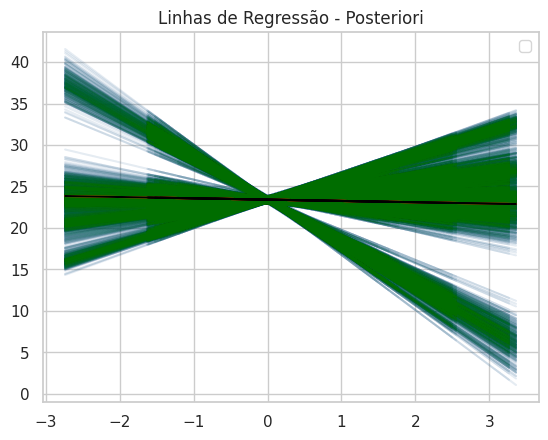

In [447]:
a_samples = auto_trace_lasso.posterior["a"].values.flatten()
b_samples = auto_trace_lasso.posterior["b"].values.flatten()

a_samples_r = auto_trace_lasso.posterior["a"].values.flatten()
b_samples_r = auto_trace_lasso.posterior["b"].values.flatten()

t_values = np.linspace(auto_X_normalizado.min(), auto_X_normalizado.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

for a_sample_r, b_sample_r in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample_r + b_sample_r * t_values, color="green", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange" )

mean_a_r = a_samples_r.mean()
mean_b_r = b_samples_r.mean()
plt.plot(t_values, mean_a_r + mean_b_r * t_values, color="black" )

#plt.scatter(t, obs_norm, color="red", alpha=0.5)

plt.xlabel("")
plt.ylabel("")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()


### Modelo 3 - regressao robusta

In [448]:
with pm.Model(coords=auto_coords) as auto_reg_robust:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1, dims='features')

  mu = a + tt.dot(auto_X_normalizado, b)

  df = pm.Exponential("df",1)

  likelihood = pm.StudentT("y_obs",nu=df,mu=mu,observed=auto_Y)

In [449]:
with auto_reg_robust:
  auto_trace_robust = pm.sample()

Output()

Output()

In [450]:
pm.summary(auto_trace_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,22.910,0.114,22.690,23.116,0.003,0.002,1907.0,1417.0,1.0
b[cylinders],-1.161,0.310,-1.750,-0.596,0.008,0.006,1387.0,1283.0,1.0
b[displacement],-0.526,0.435,-1.301,0.372,0.013,0.009,1084.0,1132.0,1.0
b[horsepower],-0.442,0.254,-0.883,0.056,0.006,0.005,1708.0,1225.0,1.0
b[weight],-2.577,0.345,-3.260,-1.971,0.011,0.008,1125.0,1025.0,1.0
b[acceleration],-0.814,0.182,-1.149,-0.475,0.005,0.003,1379.0,1460.0,1.0
b[model_year],2.171,0.115,1.943,2.376,0.003,0.002,1849.0,1392.0,1.0
b[origin],1.666,0.170,1.354,1.979,0.004,0.003,1486.0,1094.0,1.0
df,1.038,0.078,0.881,1.172,0.002,0.001,2114.0,1392.0,1.0


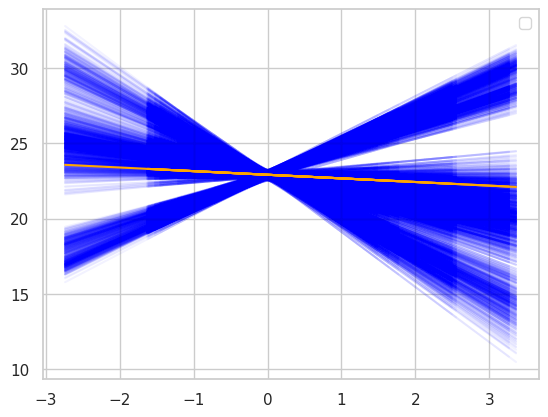

In [451]:
a_samples = auto_trace_robust.posterior["a"].values.flatten()
b_samples = auto_trace_robust.posterior["b"].values.flatten()
t_values = np.linspace(auto_X_normalizado.min(), auto_X_normalizado.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange", )

#plt.scatter(t, obs_norm, color="red", alpha=0.5)

plt.xlabel("")
plt.ylabel("")
plt.title("")
plt.legend()
plt.show()

In [452]:
with auto_reg_robust:
    auto_trace_post_rob = pm.sample_posterior_predictive(auto_trace_robust)

Output()

array([<Axes: xlabel='y_obs'>], dtype=object)

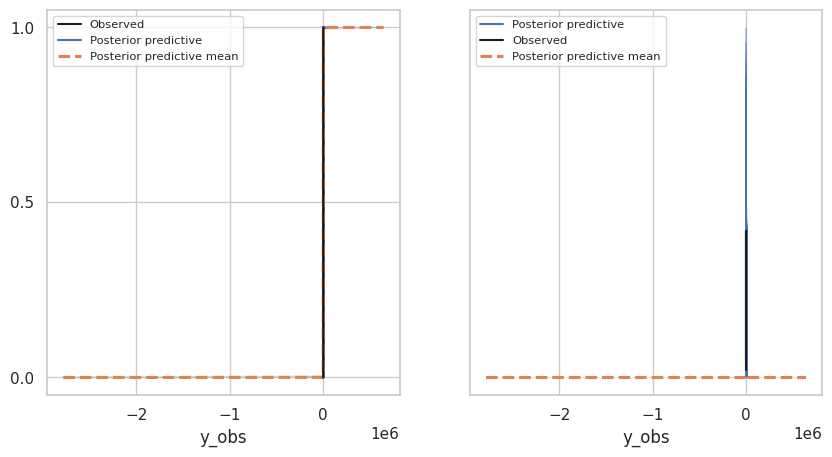

In [453]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(auto_trace_post_rob, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(auto_trace_post_rob, group='posterior', ax=axes[1])

### Log-likelihood

In [454]:
with auto_reg_model_1:
    pm.compute_log_likelihood(auto_trace)

with auto_reg_lasso:
    pm.compute_log_likelihood(auto_trace_lasso)

with auto_reg_robust:
    pm.compute_log_likelihood(auto_trace_robust)

Output()

Output()

Output()

In [ ]:
model_compare = az.compare(
    {
        "Ridge": auto_trace,
        "Lasso": auto_trace_lasso,
        "Robust": auto_trace_robust
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)


In [ ]:
model_compare